# Optimización de Hiperparámetros con Optuna

Este notebook implementa un pipeline automático de optimización de hiperparámetros usando Optuna para los **modelos basados en árboles del Notebook 05**.

1. **Carga de datos**: Lee datos de entrenamiento
2. **Definición de espacios de búsqueda**: Para modelos tree-based (XGBoost, LightGBM, CatBoost, Random Forest)
3. **Optimización con Optuna**: Búsqueda Bayesiana de hiperparámetros óptimos
4. **Validación cruzada temporal**: Evaluación robusta del rendimiento
5. **Reentrenamiento**: Con los mejores hiperparámetros encontrados
6. **Comparación**: Contra modelos del Notebook 05

**Alcance**: Solo modelos tree-based del Notebook 05. Las redes neuronales (Notebook 06: MLP, LSTM, CNN-LSTM) requieren un enfoque diferente de optimización (arquitectura, capas, neuronas, etc.).

**Objetivo**: Encontrar automáticamente la mejor configuración de hiperparámetros para cada modelo basado en árboles.

**Nota**: La validación en datos futuros se realiza en el Notebook 09 (Model Validation).

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
import joblib
import time
from datetime import datetime

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Modelos
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Optuna para optimización de hiperparámetros
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Configuración
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 6]

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Optimización de Hiperparámetros con Optuna")
print("="*60)

Optimización de Hiperparámetros con Optuna


/Users/dmar/MIA/workspace/TFM/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuración de Fechas de Entrenamiento

Define el rango de fechas para entrenamiento.

**Nota**: Estos valores pueden ser sobrescritos por el Notebook 00 (Pipeline Maestro) cuando se ejecuta automáticamente.

In [2]:
# PARÁMETROS - Esta celda puede ser sobrescrita por papermill (NB00)
# Si ejecutas este notebook manualmente, modifica estos valores aquí
# Si lo ejecutas desde NB00, estos valores serán reemplazados automáticamente

# Configuración de fechas de entrenamiento
# None = usar todos los datos disponibles desde el inicio
FECHA_INICIO_ENTRENAMIENTO = None
# Por defecto: hasta el 2025-09-20 (puedes cambiarlo según necesites)
FECHA_FIN_ENTRENAMIENTO = pd.Timestamp('2025-09-20 23:59:59')

In [3]:
# Mostrar configuración activa
print("="*80)
print("CONFIGURACIÓN DE FECHAS ACTIVA (NB06 - Optuna Optimization)")
print("="*80)
print(f"Inicio: {'Desde el principio' if FECHA_INICIO_ENTRENAMIENTO is None else FECHA_INICIO_ENTRENAMIENTO}")
print(f"Fin:    {FECHA_FIN_ENTRENAMIENTO}")
print("="*80)

CONFIGURACIÓN DE FECHAS ACTIVA (NB06 - Optuna Optimization)
Inicio: Desde el principio
Fin:    2025-09-20 23:59:59


## 1. Configuración de Optimización

In [4]:
# Configuración de la optimización
CONFIG = {
    'n_trials': 150,
    'cv_splits': 3,
    'timeout': 3600,
    'n_jobs': -1,
    'modelos_optimizar': ['xgboost', 'lightgbm', 'catboost', 'random_forest']
}

print("Configuración de optimización:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuración de optimización:
  n_trials: 150
  cv_splits: 3
  timeout: 3600
  n_jobs: -1
  modelos_optimizar: ['xgboost', 'lightgbm', 'catboost', 'random_forest']


## 2. Carga de Datos

In [5]:
# Cargar datos de entrenamiento
print("\nCargando datos...")
df_train = pd.read_parquet('artifacts/data/train_models/features_train.parquet')

# Aplicar filtros de fecha si están configurados
if FECHA_INICIO_ENTRENAMIENTO is not None:
    df_train = df_train[df_train['datetime'] >= FECHA_INICIO_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos desde {FECHA_INICIO_ENTRENAMIENTO}")
    
if FECHA_FIN_ENTRENAMIENTO is not None:
    df_train = df_train[df_train['datetime'] <= FECHA_FIN_ENTRENAMIENTO]
    print(f"Aplicando filtro: datos hasta {FECHA_FIN_ENTRENAMIENTO}")

# Cargar features seleccionadas
with open('artifacts/analysis/selected_features.json', 'r') as f:
    selected_features_data = json.load(f)
    selected_features = selected_features_data['features']

print(f"\n✓ Datos cargados: {df_train.shape}")
print(f"  Período: {df_train['datetime'].min()} a {df_train['datetime'].max()}")
print(f"  Features seleccionadas: {len(selected_features)}")

# Preparar datos
available_features = [f for f in selected_features if f in df_train.columns]
df_clean = df_train[available_features + ['demanda', 'datetime']].dropna()

X = df_clean[available_features]
y = df_clean['demanda']

print(f"\nDatos limpios:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")


Cargando datos...
Aplicando filtro: datos hasta 2025-09-20 23:59:59

✓ Datos cargados: (23856, 33)
  Período: 2023-01-01 00:00:00 a 2025-09-20 23:00:00
  Features seleccionadas: 29

Datos limpios:
  X: (23640, 29)
  y: (23640,)


## 3. Definir Funciones de Optimización

Definimos las funciones objetivo para cada modelo que Optuna optimizará.

In [6]:
# Validación cruzada temporal sobre datos de entrenamiento
tscv = TimeSeriesSplit(n_splits=CONFIG['cv_splits'])

def evaluate_model_cv(model, X, y):
    """
    Evalúa un modelo usando validación cruzada temporal sobre los datos de entrenamiento.
    Retorna el MAE promedio (métrica a minimizar).
    """
    scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Crear pipeline con escalado
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Entrenar y predecir
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        
        # Calcular MAE
        mae = mean_absolute_error(y_val_fold, y_pred)
        scores.append(mae)
    
    return np.mean(scores)

print("✓ Función de evaluación definida")
print(f"  Validación cruzada: {CONFIG['cv_splits']} splits temporales sobre datos de entrenamiento")
print(f"  Evaluación final: Test set (últimos 2 meses de features_train.parquet)")

✓ Función de evaluación definida
  Validación cruzada: 3 splits temporales sobre datos de entrenamiento
  Evaluación final: Test set (últimos 2 meses de features_train.parquet)


## 4. XGBoost - Optimización de Hiperparámetros

In [7]:
def objective_xgboost(trial):
    """
    Función objetivo para optimizar XGBoost.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'random_state': RANDOM_STATE,
        'n_jobs': CONFIG['n_jobs'],
        'tree_method': 'hist',
        'verbosity': 0
    }
    
    model = xgb.XGBRegressor(**params)
    mae = evaluate_model_cv(model, X, y)
    
    return mae

if 'xgboost' in CONFIG['modelos_optimizar']:
    print("\n" + "="*60)
    print("OPTIMIZANDO XGBOOST")
    print("="*60)
    
    study_xgb = optuna.create_study(
        direction='minimize',
        study_name='xgboost_optimization'
    )
    
    study_xgb.optimize(
        objective_xgboost,
        n_trials=CONFIG['n_trials'],
        timeout=CONFIG['timeout'],
        show_progress_bar=True
    )
    
    print(f"\n✓ Optimización completada")
    print(f"  Mejores parámetros: {study_xgb.best_params}")
    print(f"  Mejor MAE: {study_xgb.best_value:,.2f} MW")
    print(f"  Trials completados: {len(study_xgb.trials)}")


OPTIMIZANDO XGBOOST


Best trial: 94. Best value: 261.403: 100%|██████████| 150/150 [06:40<00:00,  2.67s/it, 400.42/3600 seconds]


✓ Optimización completada
  Mejores parámetros: {'n_estimators': 495, 'max_depth': 7, 'learning_rate': 0.06195310307342658, 'subsample': 0.8606232618736115, 'colsample_bytree': 0.8767778705854186, 'min_child_weight': 7, 'gamma': 0.24461168415632656, 'reg_alpha': 0.27527171042913967, 'reg_lambda': 1.1000416837458742}
  Mejor MAE: 261.40 MW
  Trials completados: 150


In [8]:
if 'xgboost' in CONFIG['modelos_optimizar']:
    # Visualizar optimización de XGBoost
    fig1 = plot_optimization_history(study_xgb)
    fig1.update_layout(title='Historial de Optimización - XGBoost', height=400)
    fig1.show()
    
    # Solo mostrar importancia de parámetros si hay al menos 2 trials
    if len(study_xgb.trials) >= 2:
        fig2 = plot_param_importances(study_xgb)
        fig2.update_layout(title='Importancia de Hiperparámetros - XGBoost', height=500)
        fig2.show()
    else:
        print(f"ADVERTENCIA: Se necesitan al menos 2 trials para calcular importancia de parámetros (completados: {len(study_xgb.trials)})")


## 5. LightGBM - Optimización de Hiperparámetros

In [9]:
def objective_lightgbm(trial):
    """
    Función objetivo para optimizar LightGBM.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'random_state': RANDOM_STATE,
        'n_jobs': CONFIG['n_jobs'],
        'verbose': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    mae = evaluate_model_cv(model, X, y)
    
    return mae

if 'lightgbm' in CONFIG['modelos_optimizar']:
    print("\n" + "="*60)
    print("OPTIMIZANDO LIGHTGBM")
    print("="*60)
    
    study_lgb = optuna.create_study(
        direction='minimize',
        study_name='lightgbm_optimization'
    )
    
    study_lgb.optimize(
        objective_lightgbm,
        n_trials=CONFIG['n_trials'],
        timeout=CONFIG['timeout'],
        show_progress_bar=True
    )
    
    print(f"\n✓ Optimización completada")
    print(f"  Mejores parámetros: {study_lgb.best_params}")
    print(f"  Mejor MAE: {study_lgb.best_value:,.2f} MW")
    print(f"  Trials completados: {len(study_lgb.trials)}")


OPTIMIZANDO LIGHTGBM


Best trial: 113. Best value: 257.637: 100%|██████████| 150/150 [28:33<00:00, 11.42s/it, 1713.34/3600 seconds]


✓ Optimización completada
  Mejores parámetros: {'n_estimators': 466, 'max_depth': 12, 'learning_rate': 0.05675152114418038, 'subsample': 0.9725109412712609, 'colsample_bytree': 0.9335404317481355, 'min_child_samples': 11, 'reg_alpha': 0.1970466975744979, 'reg_lambda': 0.03957058976539516, 'num_leaves': 85}
  Mejor MAE: 257.64 MW
  Trials completados: 150


In [10]:
if 'lightgbm' in CONFIG['modelos_optimizar']:
    # Visualizar optimización de LightGBM
    fig1 = plot_optimization_history(study_lgb)
    fig1.update_layout(title='Historial de Optimización - LightGBM', height=400)
    fig1.show()
    
    # Solo mostrar importancia de parámetros si hay al menos 2 trials
    if len(study_lgb.trials) >= 2:
        fig2 = plot_param_importances(study_lgb)
        fig2.update_layout(title='Importancia de Hiperparámetros - LightGBM', height=500)
        fig2.show()
    else:
        print(f"ADVERTENCIA: Se necesitan al menos 2 trials para calcular importancia de parámetros (completados: {len(study_lgb.trials)})")


## 6. CatBoost - Optimización de Hiperparámetros

In [11]:
def objective_catboost(trial):
    """
    Función objetivo para optimizar CatBoost.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'random_seed': RANDOM_STATE,
        'verbose': False,
        'thread_count': CONFIG['n_jobs'],
        'train_dir': None
    }
    
    model = CatBoostRegressor(**params)
    mae = evaluate_model_cv(model, X, y)
    
    return mae

if 'catboost' in CONFIG['modelos_optimizar']:
    print("\n" + "="*60)
    print("OPTIMIZANDO CATBOOST")
    print("="*60)
    
    study_cat = optuna.create_study(
        direction='minimize',
        study_name='catboost_optimization'
    )
    
    study_cat.optimize(
        objective_catboost,
        n_trials=CONFIG['n_trials'],
        timeout=CONFIG['timeout'],
        show_progress_bar=True
    )
    
    print(f"\n✓ Optimización completada")
    print(f"  Mejores parámetros: {study_cat.best_params}")
    print(f"  Mejor MAE: {study_cat.best_value:,.2f} MW")
    print(f"  Trials completados: {len(study_cat.trials)}")


OPTIMIZANDO CATBOOST


Best trial: 74. Best value: 249.624: 100%|██████████| 150/150 [06:01<00:00,  2.41s/it, 361.19/3600 seconds]


✓ Optimización completada
  Mejores parámetros: {'iterations': 468, 'depth': 8, 'learning_rate': 0.051080278799007846, 'l2_leaf_reg': 1.2734218709347624, 'bagging_temperature': 0.90353097894739, 'random_strength': 0.033181827930395716}
  Mejor MAE: 249.62 MW
  Trials completados: 150


In [12]:
if 'catboost' in CONFIG['modelos_optimizar']:
    # Visualizar optimización de CatBoost
    fig1 = plot_optimization_history(study_cat)
    fig1.update_layout(title='Historial de Optimización - CatBoost', height=400)
    fig1.show()
    
    # Solo mostrar importancia de parámetros si hay al menos 2 trials
    if len(study_cat.trials) >= 2:
        fig2 = plot_param_importances(study_cat)
        fig2.update_layout(title='Importancia de Hiperparámetros - CatBoost', height=500)
        fig2.show()
    else:
        print(f"ADVERTENCIA: Se necesitan al menos 2 trials para calcular importancia de parámetros (completados: {len(study_cat.trials)})")


## 7. Random Forest - Optimización de Hiperparámetros

In [13]:
def objective_random_forest(trial):
    """
    Función objetivo para optimizar Random Forest.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': CONFIG['n_jobs'],
        'verbose': 0
    }
    
    model = RandomForestRegressor(**params)
    mae = evaluate_model_cv(model, X, y)
    
    return mae

if 'random_forest' in CONFIG['modelos_optimizar']:
    print("\n" + "="*60)
    print("OPTIMIZANDO RANDOM FOREST")
    print("="*60)
    
    study_rf = optuna.create_study(
        direction='minimize',
        study_name='random_forest_optimization'
    )
    
    study_rf.optimize(
        objective_random_forest,
        n_trials=CONFIG['n_trials'],
        timeout=CONFIG['timeout'],
        show_progress_bar=True
    )
    
    print(f"\n✓ Optimización completada")
    print(f"  Mejores parámetros: {study_rf.best_params}")
    print(f"  Mejor MAE: {study_rf.best_value:,.2f} MW")
    print(f"  Trials completados: {len(study_rf.trials)}")


OPTIMIZANDO RANDOM FOREST


Best trial: 112. Best value: 319.467: 100%|██████████| 150/150 [33:51<00:00, 13.54s/it, 2031.24/3600 seconds]


✓ Optimización completada
  Mejores parámetros: {'n_estimators': 453, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
  Mejor MAE: 319.47 MW
  Trials completados: 150


In [14]:
if 'random_forest' in CONFIG['modelos_optimizar']:
    # Visualizar optimización de Random Forest
    fig1 = plot_optimization_history(study_rf)
    fig1.update_layout(title='Historial de Optimización - Random Forest', height=400)
    fig1.show()
    
    # Solo mostrar importancia de parámetros si hay al menos 2 trials
    if len(study_rf.trials) >= 2:
        fig2 = plot_param_importances(study_rf)
        fig2.update_layout(title='Importancia de Hiperparámetros - Random Forest', height=500)
        fig2.show()
    else:
        print(f"ADVERTENCIA: Se necesitan al menos 2 trials para calcular importancia de parámetros (completados: {len(study_rf.trials)})")


## 8. Comparación de Resultados de Optimización

In [15]:
# Recopilar resultados de optimización
optimization_results = []

if 'xgboost' in CONFIG['modelos_optimizar']:
    optimization_results.append({
        'modelo': 'XGBoost (Optuna)',
        'mae_cv': study_xgb.best_value,
        'n_trials': len(study_xgb.trials),
        'best_params': study_xgb.best_params
    })

if 'lightgbm' in CONFIG['modelos_optimizar']:
    optimization_results.append({
        'modelo': 'LightGBM (Optuna)',
        'mae_cv': study_lgb.best_value,
        'n_trials': len(study_lgb.trials),
        'best_params': study_lgb.best_params
    })

if 'catboost' in CONFIG['modelos_optimizar']:
    optimization_results.append({
        'modelo': 'CatBoost (Optuna)',
        'mae_cv': study_cat.best_value,
        'n_trials': len(study_cat.trials),
        'best_params': study_cat.best_params
    })

if 'random_forest' in CONFIG['modelos_optimizar']:
    optimization_results.append({
        'modelo': 'Random Forest (Optuna)',
        'mae_cv': study_rf.best_value,
        'n_trials': len(study_rf.trials),
        'best_params': study_rf.best_params
    })

# Crear DataFrame y ordenar por MAE
df_optimization = pd.DataFrame(optimization_results)
df_optimization = df_optimization.sort_values('mae_cv')

print("\n" + "="*70)
print("RESUMEN DE OPTIMIZACIÓN")
print("="*70)
display(df_optimization[['modelo', 'mae_cv', 'n_trials']])

print(f"\n✓ Mejor modelo: {df_optimization.iloc[0]['modelo']}")
print(f"  MAE (CV): {df_optimization.iloc[0]['mae_cv']:,.2f} MW")


RESUMEN DE OPTIMIZACIÓN


,modelo,mae_cv,n_trials
2,CatBoost (Optuna),249.624,150
1,LightGBM (Optuna),257.637,150
0,XGBoost (Optuna),261.403,150
3,Random Forest (Optuna),319.467,150



✓ Mejor modelo: CatBoost (Optuna)
  MAE (CV): 249.62 MW


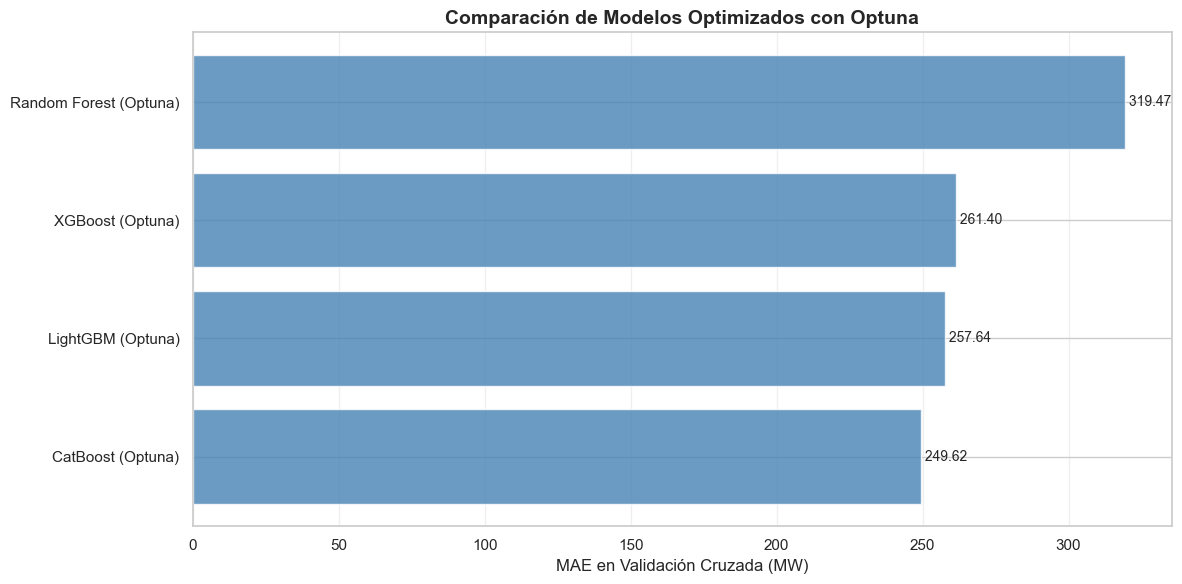

In [16]:
# Visualizar comparación
plt.figure(figsize=(12, 6))
plt.barh(df_optimization['modelo'], df_optimization['mae_cv'], color='steelblue', alpha=0.8)
plt.xlabel('MAE en Validación Cruzada (MW)', fontsize=12)
plt.title('Comparación de Modelos Optimizados con Optuna', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, v in enumerate(df_optimization['mae_cv']):
    plt.text(v, i, f' {v:,.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Guardar Resultados

In [17]:
# Crear directorio para resultados de Optuna
output_dir = Path('artifacts/optuna')
output_dir.mkdir(parents=True, exist_ok=True)

# Guardar estudios de Optuna
studies_dir = output_dir / 'studies'
studies_dir.mkdir(exist_ok=True)

if 'xgboost' in CONFIG['modelos_optimizar']:
    joblib.dump(study_xgb, studies_dir / 'study_xgboost.pkl')
    print(f"✓ Estudio XGBoost guardado")
    
if 'lightgbm' in CONFIG['modelos_optimizar']:
    joblib.dump(study_lgb, studies_dir / 'study_lightgbm.pkl')
    print(f"✓ Estudio LightGBM guardado")
    
if 'catboost' in CONFIG['modelos_optimizar']:
    joblib.dump(study_cat, studies_dir / 'study_catboost.pkl')
    print(f"✓ Estudio CatBoost guardado")
    
if 'random_forest' in CONFIG['modelos_optimizar']:
    joblib.dump(study_rf, studies_dir / 'study_random_forest.pkl')
    print(f"✓ Estudio Random Forest guardado")

print(f"\n✓ Estudios de Optuna guardados en: {studies_dir}")

# Guardar comparación de resultados
results_file = output_dir / 'optimization_results.csv'
df_optimization.to_csv(results_file, index=False)
print(f"✓ Resultados de optimización guardados: {results_file}")

print("\n" + "="*70)
print("OPTIMIZACIÓN COMPLETADA")
print("="*70)
print(f"Mejor modelo: {df_optimization.iloc[0]['modelo']}")
print(f"MAE (CV): {df_optimization.iloc[0]['mae_cv']:,.2f} MW")
print(f"\nNOTA: Los modelos optimizados se compararán en NB08 donde")
print(f"el ganador será reentrenado con train+test para producción.")
print(f"\nArchivos guardados en: {output_dir}")
print("="*70)

✓ Estudio XGBoost guardado
✓ Estudio LightGBM guardado
✓ Estudio CatBoost guardado
✓ Estudio Random Forest guardado

✓ Estudios de Optuna guardados en: artifacts/optuna/studies
✓ Resultados de optimización guardados: artifacts/optuna/optimization_results.csv

OPTIMIZACIÓN COMPLETADA
Mejor modelo: CatBoost (Optuna)
MAE (CV): 249.62 MW

NOTA: Los modelos optimizados se compararán en NB08 donde
el ganador será reentrenado con train+test para producción.

Archivos guardados en: artifacts/optuna
